# MC Slowing Down using OpenMC Data

In [5]:
%matplotlib inline

import openmc
import numpy as np
import matplotlib.pyplot as plt
import random
import math

In [6]:
A_h = 1
alpha_h = 0
h_xs = 20   #Fixed 20 barns H-1 scattering cross-section

In [7]:
energies = np.logspace(0,4,100)
log_del = np.log(1e4)/100

Here we define that our problem contains H-1 and U-238, we compute the $\alpha$ values, assign the nuclide densities and then calculates the dilution cross section.  We will assume that the hydrogen cross section is flat and exactly 20b, but we will use the real U-238 cross-section.  We will caculate effective resonance integrals over 3 groups encompassing the three low-energy resonances.

In [8]:
def MC_slowing_down(N_h,b,Estart,nps):
    random.seed(a=2)
    abs_counter = 0.0
    flux_counter = np.zeros(len(energies))
    for i in range(nps):
        E= Estart
        while (E>1.0):
            #Calculate Sigma_t, the next two lines read the abs and scat xs of U-238 at energy E, 
            #linear interpolation is performed automatically between the nearest values in the library.
            Sigma_t = b*N_h*h_xs
            if E<10000.0:
                index = math.floor(np.log(E)/log_del)
                flux_counter[index] = flux_counter[index] + 1/Sigma_t
            # Sample which nuclide we are colliding with
            rng1 = random.random()
            if rng1<(N_h*h_xs / Sigma_t):
                Eprime = E*random.random()
            else:
                abs_counter = abs_counter + 1
                Eprime = 0.0
            E = Eprime
    flux_counter = flux_counter/nps
    return flux_counter, abs_counter

In [14]:
b = np.array([1.00, 1.01, 1.02, 1.03])
res_int = np.zeros([5,len(b)])
flux_int = np.zeros([5,len(b)])
dilution = np.zeros(len(b))
tmp_flux = np.zeros([len(b),len(energies)])
absorbed = np.zeros(len(b))
for j in range(len(b)):
    tmp_flux[j,:], absorbed[j] = MC_slowing_down(10.0,b[j],200000,500000)

(0.0, 0.0005)

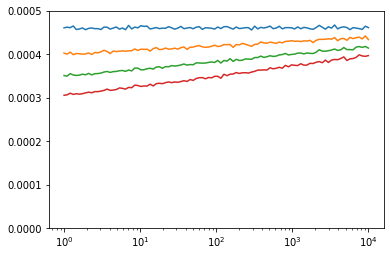

In [21]:
plt.semilogx(energies,tmp_flux[0,:])
plt.semilogx(energies,tmp_flux[1,:])
plt.semilogx(energies,tmp_flux[2,:])
plt.semilogx(energies,tmp_flux[3,:])
plt.ylim([0.0,0.0005])

In this plot, we can see the dip of the flux at the energy of the three main s-wave resonances of U-238. We can also see that the flux is flat when tallied on a log space energy grid.  Additionally, we can see that the flat flux decreases like a staircase after neutrons slow down pass a resonance.  We call this energy self-shielding.  The 36.6 eV resonance is shielding the 20.87 eV and 6.67 eV resonances by reducing the number of neutrons that these resonances can see.

When picking group boundaries, we have to make sure that the flux didn't drop too much within a group since it impacts the source magnitude that each group will see.

In [24]:
for i in range(len(b)):
    res_esc = (500000 - absorbed[i])/500000
    print(b[i],res_esc)

1.0 1.0
1.01 0.87739
1.02 0.77231
1.03 0.681302
